The following codes are originally from [here](https://bipinkrishnan.github.io/ml-recipe-book/image_segmentation.html), and slightly modified

In this chapter, instead of classifying the images into a category, we will segment roads present in the image. If we are segmenting roads in an image, what the models is trying to do is predict whether each pixel in the input image belongs to a road or not: The pixels that belong to the road should be equal to 1 and all other pixels should be equal to 0.

# 0. Dataset

All the data that we will be using for this chapter is inside the ‘training’ folder. The training folder has two sub-folders, `gt_image_2` and `image_2` which contains our segmentation mask and its corresponding images respectively.

In [1]:
from PIL import Image

In [2]:
sample_image_path = "../data/kittiroadsegmentation/training/image_2/um_000000.png"
sample_segmented_image_path = (
    "../data/kittiroadsegmentation/training/gt_image_2/um_lane_000000.png"
)

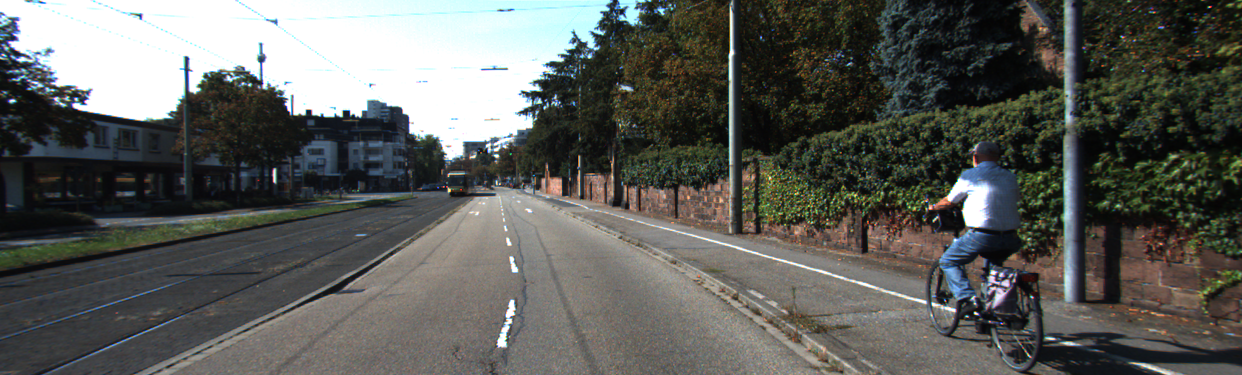

In [3]:
Image.open(sample_image_path)

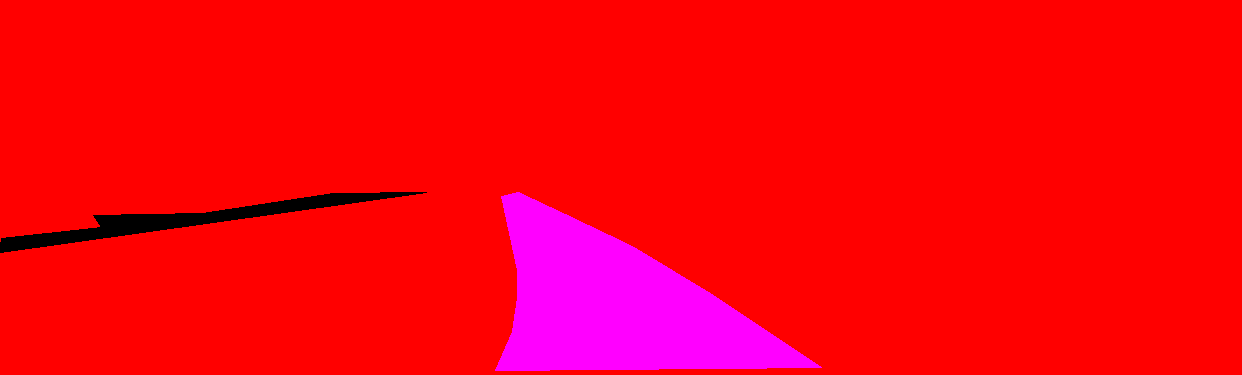

In [4]:
Image.open(sample_segmented_image_path)

# 1. Preparing the dataframe

Now let’s write some code to create a dataframe where each row contains the path to image and its corresponding segmentation mask.

> Note: If `image_2` folder has a file named ‘um_000000.png’, its corresponding segmentation mask will have the name ‘um_lane_000000.png’. We will exploit this pattern to extract all image paths and its segmentation mask files.

In [5]:
from pathlib import Path

In [6]:
img_root_path = Path("../data/kittiroadsegmentation/training/image_2")
mask_root_path = Path("../data/kittiroadsegmentation/training/gt_image_2")

In [7]:
# all image file names are retrieved
img_files = img_root_path.glob("*")

Now let’s loop through each image file name and check if it’s segmentation mask file is also present:

In [8]:
import os

In [9]:
def get_existing_imgs_and_masks(img_files, mask_root_path):
    existing_imgs, existing_masks = [], []

    for img_file in img_files:
        mask_file = f"{mask_root_path}/um_lane_{str(img_file).split('_')[-1]}"

        if os.path.exists(mask_file):
            existing_imgs.append(img_file)
            existing_masks.append(mask_file)

    return existing_imgs, existing_masks

In [10]:
imgs, masks = get_existing_imgs_and_masks(img_files, mask_root_path)

In [11]:
imgs[:3]  # imgs samples

[WindowsPath('../data/kittiroadsegmentation/training/image_2/umm_000000.png'),
 WindowsPath('../data/kittiroadsegmentation/training/image_2/umm_000001.png'),
 WindowsPath('../data/kittiroadsegmentation/training/image_2/umm_000002.png')]

In [12]:
masks[:3]  # masks samples

['..\\data\\kittiroadsegmentation\\training\\gt_image_2/um_lane_000000.png',
 '..\\data\\kittiroadsegmentation\\training\\gt_image_2/um_lane_000001.png',
 '..\\data\\kittiroadsegmentation\\training\\gt_image_2/um_lane_000002.png']

Now let’s put both `imgs` and `masks` into a dataframe:

In [13]:
import pandas as pd

In [14]:
df = pd.DataFrame(columns=["imgs"])

df["imgs"] = imgs
df["masks"] = masks

In [15]:
df.head()

,imgs,masks
0,..\data\kittiroadsegmentation\training\image_2...,..\data\kittiroadsegmentation\training\gt_imag...
1,..\data\kittiroadsegmentation\training\image_2...,..\data\kittiroadsegmentation\training\gt_imag...
2,..\data\kittiroadsegmentation\training\image_2...,..\data\kittiroadsegmentation\training\gt_imag...
3,..\data\kittiroadsegmentation\training\image_2...,..\data\kittiroadsegmentation\training\gt_imag...
4,..\data\kittiroadsegmentation\training\image_2...,..\data\kittiroadsegmentation\training\gt_imag...


Now split the dataframe into training and evaluation sets:

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_df, eval_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

# 2. Loading the images and masks

Finally, we are ready to write our dataset loading class using pytorch. These are the steps we will follow while loading our images and masks:

1) Get the image path and its mask file path

In [18]:
sample_img_path = str(imgs[0])
sample_mask_path = str(masks[0])

In [19]:
sample_img_path

'..\\data\\kittiroadsegmentation\\training\\image_2\\umm_000000.png'

In [20]:
sample_mask_path

'..\\data\\kittiroadsegmentation\\training\\gt_image_2/um_lane_000000.png'

2) Load the image using `opencv`, convert from BGR to RGB format and normalize it by dividing by 255.

In [21]:
import cv2
import matplotlib.pyplot as plt

In [22]:
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB) / 255.0

In [23]:
sample_img.shape

(375, 1242, 3)

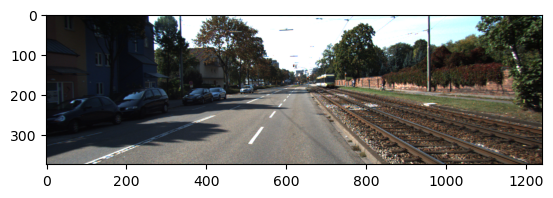

In [24]:
plt.imshow(sample_img)

3) For the segmentation mask we don’t need all the 3 channels, so we load in our mask using opencv, normalize it and take only the first channel:

In [25]:
sample_mask = cv2.imread(sample_mask_path) / 255.0
sample_mask = sample_mask[:, :, 0]

In [26]:
sample_mask.shape

(375, 1242)

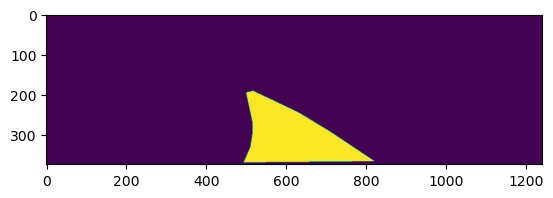

In [27]:
plt.imshow(sample_mask)

4) Now we will make sure that the segmentation mask has only 1’s and 0’s (1 for pixels belonging to road and 0 for others).

In [28]:
sample_mask = (sample_mask == 1).astype(float)

5) Now we will resize the image and mask and convert them to pytorch tensors. For this, we will use the ‘albumentations’ library which is commonly used by the machine learning community.

In [29]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [30]:
# resize and convert to tensors
transform = A.Compose([A.Resize(256, 256), ToTensorV2()])
augmented = transform(image=sample_img, mask=sample_mask)

In [31]:
augmented

{'image': tensor([[[0.1059, 0.1050, 0.1010,  ..., 0.0985, 0.0418, 0.0955],
          [0.1059, 0.1014, 0.0980,  ..., 0.0845, 0.0355, 0.1353],
          [0.1077, 0.0973, 0.1059,  ..., 0.0648, 0.1022, 0.5303],
          ...,
          [0.5271, 0.4494, 0.4827,  ..., 0.2860, 0.3065, 0.3160],
          [0.5026, 0.4812, 0.4738,  ..., 0.2660, 0.2632, 0.1709],
          [0.5124, 0.4844, 0.4496,  ..., 0.2603, 0.1651, 0.2473]],
 
         [[0.0901, 0.0786, 0.0854,  ..., 0.0719, 0.0468, 0.3534],
          [0.0874, 0.0848, 0.0813,  ..., 0.0731, 0.0523, 0.4839],
          [0.0856, 0.0876, 0.0830,  ..., 0.0608, 0.0994, 0.7500],
          ...,
          [0.5051, 0.4584, 0.4981,  ..., 0.2087, 0.2325, 0.1972],
          [0.4932, 0.4702, 0.5018,  ..., 0.2090, 0.1616, 0.1015],
          [0.4804, 0.4900, 0.4724,  ..., 0.2157, 0.1102, 0.1160]],
 
         [[0.0902, 0.0826, 0.0848,  ..., 0.1856, 0.0473, 0.4124],
          [0.0902, 0.0854, 0.0811,  ..., 0.2435, 0.0452, 0.6631],
          [0.1023, 0.0811, 0.07

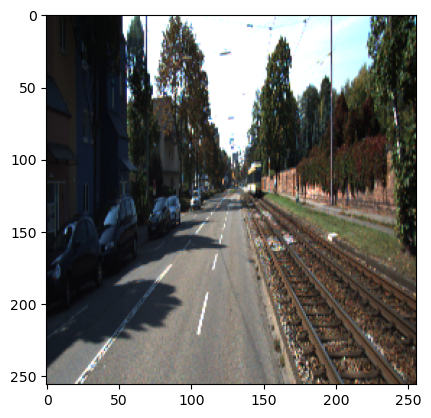

In [32]:
plt.imshow(augmented["image"].permute(1, 2, 0))

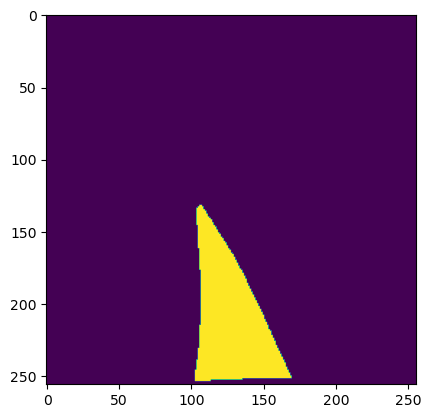

In [33]:
plt.imshow(augmented["mask"])

6) Right now, the size of our image and masks are (3, 256, 256) and (256, 256) respectively. We need to convert our mask to (1, 256, 256) and the data type of our image to `FloatTensor`. Otherwise, we will get errors while training.

In [34]:
import torch

In [35]:
augmented["mask"] = augmented["mask"].unsqueeze(0)
augmented["image"] = augmented["image"].type(torch.FloatTensor)

And that’s it, we will wrap all of the above steps into our data loading class:

In [36]:
from torch.utils.data import Dataset

In [37]:
class LoadDataset(Dataset):
    def __init__(self, img_paths, mask_paths):
        self.imgs = img_paths
        self.masks = mask_paths
        self.transform = A.Compose([A.Resize(256, 256), ToTensorV2()])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(str(self.imgs[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

        mask = cv2.imread(str(self.masks[idx])) / 255.0
        mask = (mask[:, :, 0] == 1).astype(float)

        augmented = self.transform(image=img, mask=mask)
        augmented["image"] = augmented["image"].type(torch.FloatTensor)
        augmented["mask"] = augmented["mask"].unsqueeze(0)

        return augmented

Now let’s load our training and evaluation datasets using the above class:

In [38]:
train_ds = LoadDataset(train_df["imgs"].values, train_df["masks"].values)
eval_ds = LoadDataset(eval_df["imgs"].values, eval_df["masks"].values)

In [39]:
train_ds[0]

{'image': tensor([[[0.0700, 0.0910, 0.1130,  ..., 0.8402, 0.8713, 0.8547],
          [0.0835, 0.0640, 0.2458,  ..., 0.8419, 0.8453, 0.8483],
          [0.0981, 0.0570, 0.1320,  ..., 0.8468, 0.8548, 0.8839],
          ...,
          [0.7170, 0.7184, 0.7585,  ..., 0.0844, 0.0821, 0.0824],
          [0.6945, 0.7176, 0.7144,  ..., 0.0877, 0.0681, 0.0781],
          [0.6972, 0.7193, 0.6718,  ..., 0.0858, 0.0751, 0.0728]],
 
         [[0.1037, 0.0953, 0.1154,  ..., 0.4784, 0.4717, 0.4743],
          [0.0973, 0.0890, 0.1492,  ..., 0.4691, 0.4802, 0.4747],
          [0.1052, 0.1022, 0.1491,  ..., 0.4781, 0.4773, 0.4738],
          ...,
          [0.6910, 0.6878, 0.7360,  ..., 0.0896, 0.1072, 0.1033],
          [0.6872, 0.7055, 0.7213,  ..., 0.0946, 0.0956, 0.1068],
          [0.7286, 0.6947, 0.8511,  ..., 0.1037, 0.0978, 0.1020]],
 
         [[0.0579, 0.0929, 0.0898,  ..., 0.0583, 0.0446, 0.0505],
          [0.0692, 0.0827, 0.0935,  ..., 0.0485, 0.0474, 0.0536],
          [0.0824, 0.0782, 0.09

In [40]:
eval_ds[0]

{'image': tensor([[[0.7065, 0.6910, 0.7013,  ..., 0.0950, 0.0504, 0.0264],
          [0.7038, 0.7089, 0.6846,  ..., 0.0569, 0.0479, 0.0407],
          [0.6983, 0.7137, 0.7141,  ..., 0.0542, 0.0928, 0.0767],
          ...,
          [0.2739, 0.3763, 0.4736,  ..., 0.0589, 0.0386, 0.0410],
          [0.3711, 0.4583, 0.4143,  ..., 0.0663, 0.0494, 0.0355],
          [0.3879, 0.4580, 0.3826,  ..., 0.0745, 0.0875, 0.0735]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.1058, 0.0665, 0.0251],
          [1.0000, 1.0000, 1.0000,  ..., 0.0529, 0.0545, 0.0368],
          [1.0000, 1.0000, 1.0000,  ..., 0.0453, 0.0666, 0.0757],
          ...,
          [0.3244, 0.3339, 0.3464,  ..., 0.0730, 0.0458, 0.0601],
          [0.3110, 0.3764, 0.3573,  ..., 0.0984, 0.0609, 0.0562],
          [0.3236, 0.3439, 0.4291,  ..., 0.0999, 0.1000, 0.0673]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.0396, 0.0196, 0.0157],
          [1.0000, 1.0000, 1.0000,  ..., 0.0256, 0.0251, 0.0207],
          [1.0000, 1.0000, 1.00

# 2. Training the model

We will use pytorch lightning for our training :) So let’s build our model class using the `LightningModule` from pytorch lightning.

For this task, we will use a **unet model** which is a commonly used one for image segmentation. This model is like an encoder-decoder model, we can replace the encoder part with any of the commonly used convolutional neural networks(vgg, resnet etc). Here we will use ‘resnet34’ as our encoder/backbone. In short, we will use a unet model with ‘resnet34’ backbone.

So let’s load in the unet model from `segmentation-models-pytorch` library:

In [41]:
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from torch import optim
from torch.utils.data import DataLoader

In [42]:
class SegmentationModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 1e-3
        self.batch_size = 32

        self.model = smp.Unet(
            "resnet34", classes=1, activation=None, encoder_weights="imagenet"
        )

    def forward(self, x):
        return self.model(x)

    def train_dataloader(self):
        return DataLoader(train_ds, batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return DataLoader(eval_ds, batch_size=self.batch_size, shuffle=False)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["mask"]
        out = self.model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["mask"]
        out = self.model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.model.parameters(), lr=self.learning_rate)

The only part remaining is to train our model and that is as simple as passing the model and epochs to our pytorch lightning trainer:

In [43]:
from pytorch_lightning import Trainer

In [44]:
model = SegmentationModel()

In [45]:
trainer = Trainer(
    accelerator="auto",  # automatically select the available accelerator(CPU, GPU, TPU etc)
    devices=1,  # select the available one device of the accelerator
    # auto_lr_find=True,   # use learning rate finder to set the learning rate (Not available in 2.0.2)
    max_epochs=5,  # number of epochs to train
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:
# trainer.tune(model)  # this is for auto_lr_find (Not available in 2.0.2)

In [47]:
trainer.fit(model)


  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# 3. Testing the model

In [48]:
idx = 0
img = eval_ds[idx]["image"]
mask = eval_ds[idx]["mask"]

In [49]:
# prediction
model.eval()
with torch.no_grad():
    pred_probability = model(img.unsqueeze(0))
    pred_probability = torch.sigmoid(pred_probability)
    pred = (pred_probability > 0.5).type(torch.int)

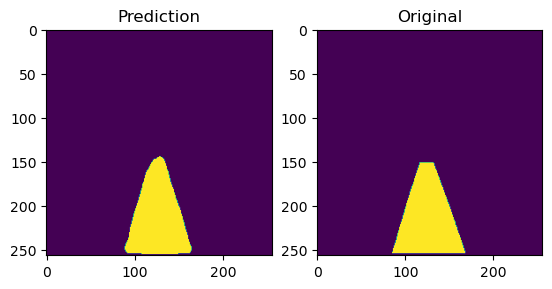

In [50]:
plt.subplot(1, 2, 1)
plt.imshow(pred.squeeze())
plt.title('Prediction')

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze())
plt.title("Original");